In [1]:
#setup
data_dir='../../Data/Weather'
file_index='BBBBSSBB'
#meas='PRCP'
meas='SNWD'

# Reconstruction using top eigen-vectors
For measurement = {{meas}}

## Load the required libraries

In [2]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [3]:
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.12.1 	required version>=1.12.0
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [4]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)





## Read Statistics File

In [5]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [6]:
#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==meas)
df.show(5)

+-----------------+------------------+------------------+------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+--------------------+--------------------+------------------+-----------+--------------------+------+--------------------+------+
|          coeff_1|           coeff_2|           coeff_3|           coeff_4|elevation|   label|latitude|longitude|measurement|              res_1|              res_2|               res_3|               res_4|          res_mean|    station|           total_var|undefs|              vector|  year|
+-----------------+------------------+------------------+------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+--------------------+--------------------+------------------+-----------+--------------------+------+--------------------+------+
|9171.110131269304| 2087.753769407183|  2267.78139762957|480.25180925690347|    532.8|BBBBSSBB| 43.7025| -74.983

### Plot Mean and Eigenvecs

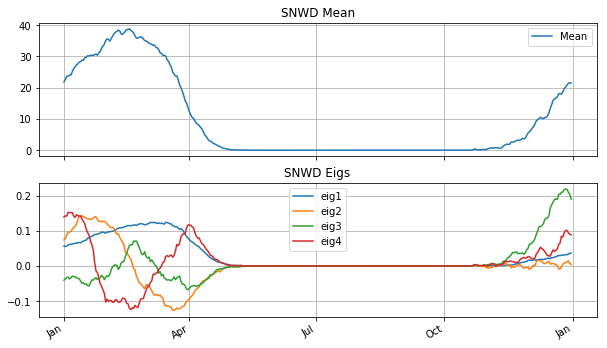

In [7]:
m=meas
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=4
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']/10.
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

### plot the percent of residual variance on average

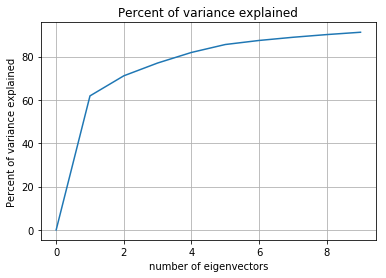

In [8]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

### How well-explained are the vectors in this collection?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

In [9]:
# A function for plotting the CDF of a given feature
def plot_CDF(df,feat):
    rows=df.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1,1./(len(vals)))
    while len(vals)< len(P):
        vals=[vals[0]]+vals
    plot(vals,P)
    title('cumulative distribution of '+feat)
    ylabel('fraction of instances')
    xlabel(feat)
    grid()
    

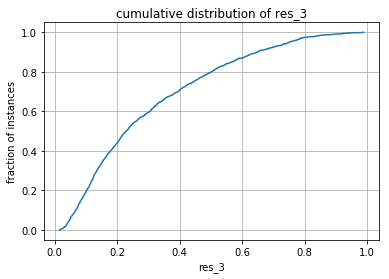

In [10]:
plot_CDF(df,'res_3')

In [11]:
rows=df.rdd.map(lambda row:(row.station,row.year,unpackArray(row['vector'],np.float16))).collect()
rows[0][:2]

(u'USC00306184', 1977.0)

In [12]:
days=set([r[1] for r in rows])
miny=min(days)
maxy=max(days)
record_len=int((maxy-miny+1)*365)
record_len

41245

In [13]:
## combine the measurements for each station into a single long array with an entry for each day of each day
All={}  # a dictionary with a numpy array for each day of each day
i=0
for station,day,vector in rows:
    i+=1; 
    # if i%1000==0: print i,len(All)
    if not station in All:
        a=np.zeros(record_len)
        a.fill(np.nan)
        All[station]=a
    loc = int((day-miny)*365)
    All[station][loc:loc+365]=vector

In [14]:
from datetime import date
d=datetime.date(int(miny), month=1, day=1)
start=d.toordinal()
dates=[date.fromordinal(i) for i in range(start,start+record_len)]

In [15]:
for station in All:
    print station, np.count_nonzero(~np.isnan(All[station]))

USC00301732 1788
USC00309000 18997
USC00300018 690
USC00300785 22687
US1NYOD0023 1055
USC00306184 12993
USC00308503 365
USC00300870 12403
USC00300500 14071
USC00303889 3397
USC00309544 1760
USC00308036 730
USC00300015 319
USC00300379 6140
USC00300424 2460
USC00301708 12413
USC00305751 334
USC00307413 10456
USC00304102 4009
USC00308578 331
USC00306623 10844
USC00303087 1311
USC00301110 9247
USC00300668 10081
USC00307129 5618
USC00305438 344
USW00014717 16705
USC00300608 18419
USC00303299 1028
USC00308080 9635
USC00305658 696
USC00302047 722
USC00303416 3625
USC00302045 1061
USW00014772 1095
USC00309389 3419
USC00300780 3824
USC00305769 2760
USC00309248 1440
USC00305925 17230
USC00308104 8472
USC00304912 14075
US1NYOG0046 359
CA006150815 320
USC00303970 7912
US1NYOD0014 329
USC00303961 6107
USC00306965 1449
USW00014774 694
USC00300368 11395
USC00306867 2187
USC00307405 11626
USC00309480 332
USC00302917 3927
USC00308248 10623
USC00306062 16327
USW00014771 26955
USC00307524 690
USC00304984

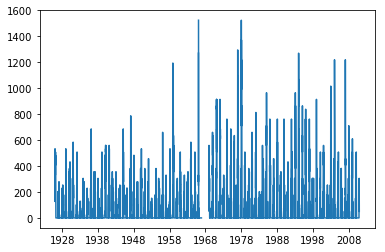

In [16]:
plot(dates,All['USC00306314']);

In [17]:
Stations=sorted(All.keys())
A=[]
for station in Stations:
    A.append(All[station])

day_station_table=np.hstack([A])
print shape(day_station_table)

(70, 41245)


(2887150,) (520742,) (155240,)


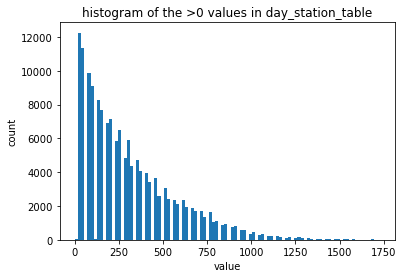

In [18]:
RT=day_station_table
F=RT.flatten()
NN=F[~np.isnan(F)]
NZ=NN[NN>0]
print shape(F),shape(NN),shape(NZ)

hist(NZ,bins=100);
title('histogram of the >0 values in day_station_table')
xlabel('value')
ylabel('count')

In [19]:
def RMS(Mat):
    return np.sqrt(np.nanmean(Mat**2))

mean_by_day=np.nanmean(day_station_table,axis=0)
mean_by_station=np.nanmean(day_station_table,axis=1)
tbl_minus_day = day_station_table-mean_by_day
tbl_minus_station = (day_station_table.transpose()-mean_by_station).transpose()

print 'total RMS                   = ',RMS(day_station_table)
print 'RMS removing mean-by-station= ',RMS(tbl_minus_station)
print 'RMS removing mean-by-day   = ',RMS(tbl_minus_day)

total RMS                   =  221.745634054
RMS removing mean-by-station=  195.558167929
RMS removing mean-by-day   =  113.998359612


/Users/jc/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: Mean of empty slice


In [20]:
#Normalize rows of RT to have norm 1
Len=sqrt(np.nansum(tbl_minus_day**2,axis=1))
NRT=(tbl_minus_day.transpose()/Len).transpose()

/Users/jc/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


In [21]:
K=5  # the number of time-shifts we consider
Middle=K/2 # the index (among K) of the zero-time-shift
n,m=RT.shape
TK=np.empty([n*K,m-K],dtype=numpy.float64)

#create the shifts
for i in range(K):
    TK[i::K,:]=NRT[:,i:-K+i]

#zero Nan entries and indicate them in a separate matrix
TKnan=np.isnan(TK)
TK[TKnan]=0
TK1nan=1-TKnan*1

TT=NRT[:,Middle:-Middle-1]
TTnan=np.isnan(TT)
TT1nan=1-TTnan*1
TT[TTnan]=0
print 'shape of sequence matrix (TT) %s, shape of matrix with %d shifts (TK) %s'%\
    (str(TT.shape),K,str(TK.shape))
#print sum(TK1nan,axis=1)
#print sum(TT1nan)

shape of sequence matrix (TT) (70, 41240), shape of matrix with 5 shifts (TK) (350, 41240)


In [22]:
Prod=np.dot(TK,TT.transpose())
print shape(Prod)
print sum(np.isnan(Prod.flatten()))

(350, 70)
0


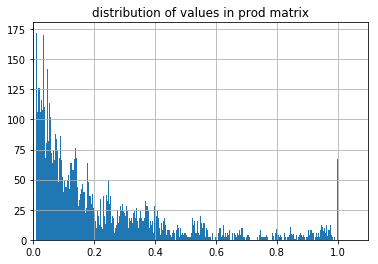

In [23]:
hist(Prod[Prod>0.01].flatten(),bins=300);
xlim([0.0,1.1])
title('distribution of values in prod matrix')
grid()
#showmat(ProdMean[:100,:100].transpose())

In [24]:
n,m

(70, 41245)

In [25]:
_shift=np.empty([n,n])
_max=np.empty([n,n])
for i in range(n):
    Slice=Prod[i*K:(i+1)*K,:]
    _shift[i,:]=np.argmax(Slice,axis=0)  #find best shift
    _max[i,:]=np.max(Slice,axis=0) #find max correlation

In [26]:
def showmat(mat):
    fig,axes=plt.subplots(1,1,figsize=(10,10))
    axes.matshow(mat)

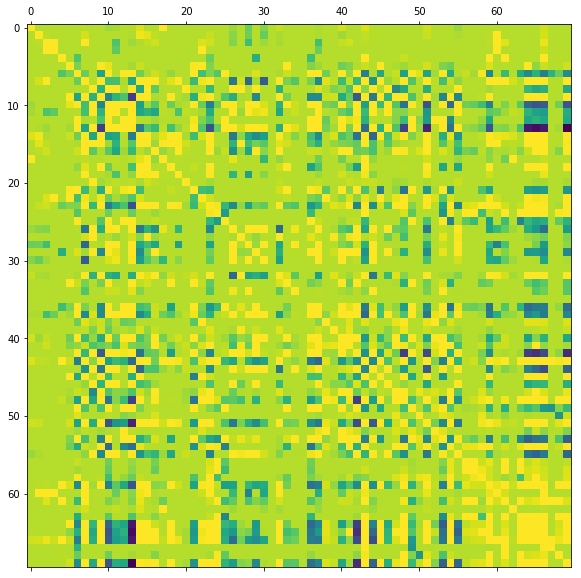

In [27]:
_max2=_max*10.
_max2[_max2>1.]=1.
showmat(_max2)
#showmat(_max*(_max>0.2))

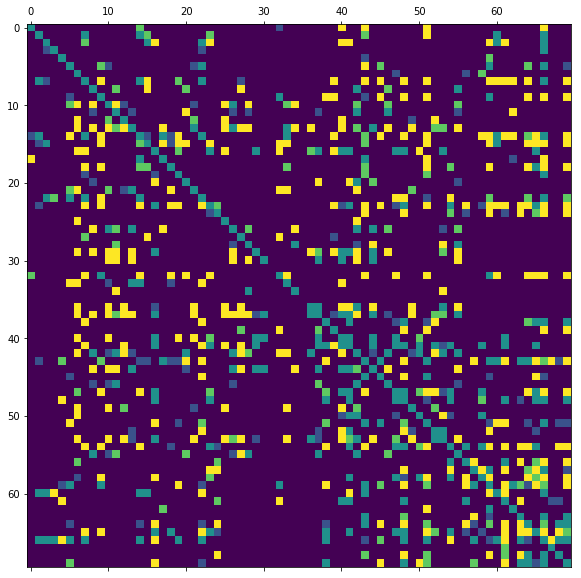

In [28]:
_Sshift=_shift*(_max>0.01)
showmat(_Sshift)

In [29]:
print min(_Sshift.flatten()),max(_Sshift.flatten())

0.0 4.0


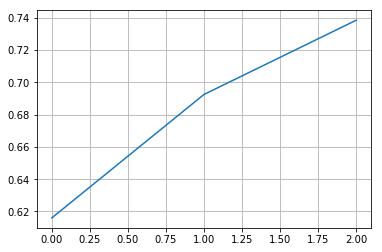

In [30]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, svd_solver='full')
pca.fit(_max)     
#print(pca.explained_variance_)
Var_explained=pca.explained_variance_ratio_
plot(cumsum(Var_explained))
grid()

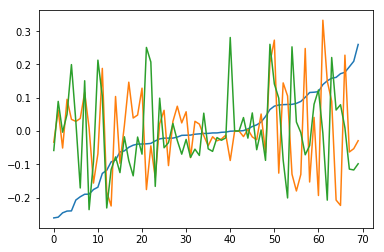

In [31]:
L=list(pca.components_.transpose())
X=sorted(L,key=lambda x:x[0]) 
plot(X);
#(key=lambda x:x[0])

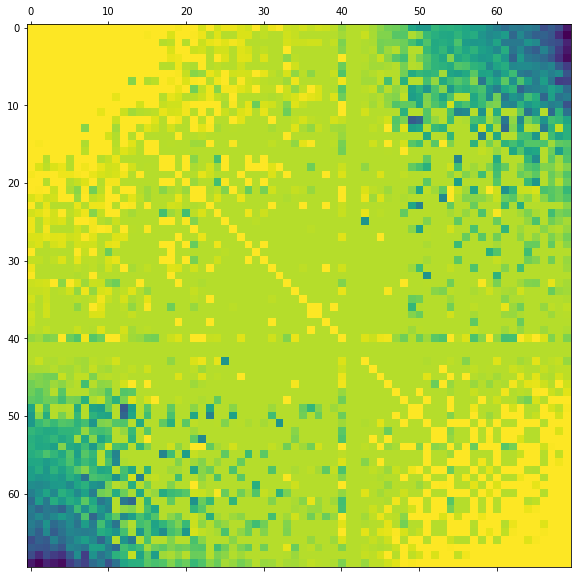

In [32]:
order=np.argsort(pca.components_[0,:])
_max_reord=_max[order,:]
_max_reord=_max_reord[:,order]
_max2=_max_reord*10.
_max2[_max2>1.]=1.
showmat(_max2)

(3, 70)


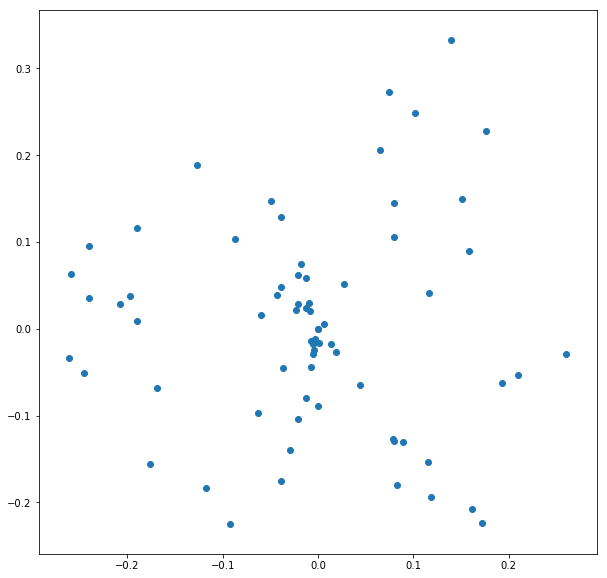

In [33]:
comp_=pca.components_
figure(figsize=(10,10))
print shape(comp_)
scatter(comp_[0,:],comp_[1,:]);